In [329]:
import torch
import matplotlib.pyplot as plt

In [330]:
# Setup

# Set manual seed for reproducability
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    device= torch.device('cuda')
else:
    device= torch.device('cpu')
# Used for graphing
cpu_device= torch.device('cpu')
# Set default dtype
torch.set_default_dtype(torch.float64)
torch.set_default_device(device)

In [331]:
def relative_error(u, v):
    """
    Description:
        This is a helper function that implements relative error
        between to vectors u and v in a normalized way. Which will be used
        check the gradient descent implementation
    """
    # Compute L2 Norms of u - v
    diff_norm= torch.linalg.norm(u - v)

    # Compute L2 Norms for both u and v
    u_norm= torch.linalg.norm(u)
    v_norm= torch.linalg.norm(v)

    # Compute the denominator: max(1, ||u||_2, ||v||_2)
    # This ensures we never have very small nums in our denom
    denominator= torch.max(torch.tensor(1.0), torch.max(u_norm, v_norm))

    return diff_norm / denominator

In [332]:
def loss_difference(loss1, loss2):
    """
    Description:
        This is a helper function that will be used to compare
        the losses of the two solutions (GD and closed form) 
    """
    return abs(loss1 - loss2)

In [333]:
def generate_data(n, d, kappa, noise_std= 0.01, seed= None):
    """
    Description:
        Generate synthetic data with specified condition number
        This will help create well conditioned and ill-conditioned problems
        to gain insight during comparison of linear regression vs gradient descent
    Args:
        n: Number of samples
        d: Number of features
        kappa: target condition number(k)
        noise_std: Standard deviation of noise (default: 0.01)
        seed: Random seed for reproducibility
    Returns:
        X: Feature matrix of shape (n, d)
        y: Target vector of shape (n,)
        beta_star: Ground truth coefficients of shape (d,)
    """
    if seed is not None:
        torch.manual_seed(42)
    

    # Step 1: Generate randomm Gaussian matrices and get U, V via QR
    # Create random matrix of shape (n, d)
    A= torch.randn(n, d)
    # QR Decomposition to get orthonormal cols in Q
    U, _= torch.linalg.qr(A)
    # Create random matrix of shape (d, d)
    B= torch.randn(d, d)
    # QR decomposition to get orthogonal matrix V
    V, _= torch.linalg.qr(B)

    # Step 2: Set singular values s to be geometrically spaced between 1 and 1/k
    # We need d singular values for a matrix of shape (n, d)
    s= torch.logspace(0, -torch.log10(torch.tensor(kappa)), d)

    # Step 3: Build X = U * diag(S) * V^T
    # Create diagonal matrix from singular vals
    S= torch.diag(s)
    # Compute X
    X= U @ S @ V.T

    # Step 5: Generate Ground truth b_star (Standard Normal)  
    beta_star= torch.randn(d)

    # Step 5: Generate y= X * B_star + epsilon
    # Compute Noise
    epsilon= torch.randn(n) * noise_std
    # Compute y
    y= X @ beta_star + epsilon

    return X, y, beta_star

In [334]:
def plot_2d_scatter(X, y, title="Dataset Visualization"):
    """
    Create a 2D scatter plot of the first two features, colored by the target value.
    
    Args:
        X: Feature matrix of shape (n, d)
        y: Target vector of shape (n,)
        title: Plot title
    """
    plt.figure(figsize=(10, 8))
    
    # Create scatter plot
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.8)
    
    # Add colorbar
    plt.colorbar(scatter, label='Target Value (y)')
    
    # Add labels and title
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    
    # Add grid
    plt.grid(True, alpha=0.3)
    
    plt.show()

## Brief Explanation of Well and Ill-Conditioned Data

The condition number of a matrix measures how sensitive the solution is to small changes in the input. In linear regression, it primarily refers to the design matrix $X$ (or $X^T X$ in normal equations).

The condition number is defined as:
$\kappa(X) = \frac{\sigma_{\text{max}}}{\sigma_{\text{min}}}$
where $\sigma_{\text{max}}$ and $\sigma_{\text{min}}$ are the largest and smallest singular values of $X$.

### Well-Conditioned Data (Low Condition Number, typically < 100)
Indicates:
1. **Numerical Stability**: Solutions are robust to small perturbations in data
2. **Reliable Estimates**: Coefficients are accurately estimated with low variance
3. **Fast Convergence**: Gradient descent converges quickly with consistent steps
4. **Consistent Performance**: Similar results across different optimization methods
5. **Isotropic Loss Landscape**: The loss function has similar curvature in all directions

### Ill-Conditioned Data (High Condition Number, typically > 1000)
Indicates:
1. **Numerical Instability**: Small data changes cause large coefficient changes
2. **Unreliable Estimates**: Coefficients can have large variances and high sensitivity
3. **Slow Convergence**: Gradient descent struggles with narrow valleys in the loss landscape
4. **Overfitting Risk**: Model may fit noise rather than signal
5. **Poor Generalization**: Test performance degrades significantly
6. **Anisotropic Loss Landscape**: The loss function has dramatically different curvatures in different directions


Note for the visualizations below:

- well conditioned data look almost ciruclar which means the features in X are highly independent which is useful for the reasons above and for also learning useful information and patterns about the data.

- ill conditioned data are nearly in the shape of a straight line which shows high multicollinearity between the features and high dependency which makes it challenging to learn meaningful representations of the data

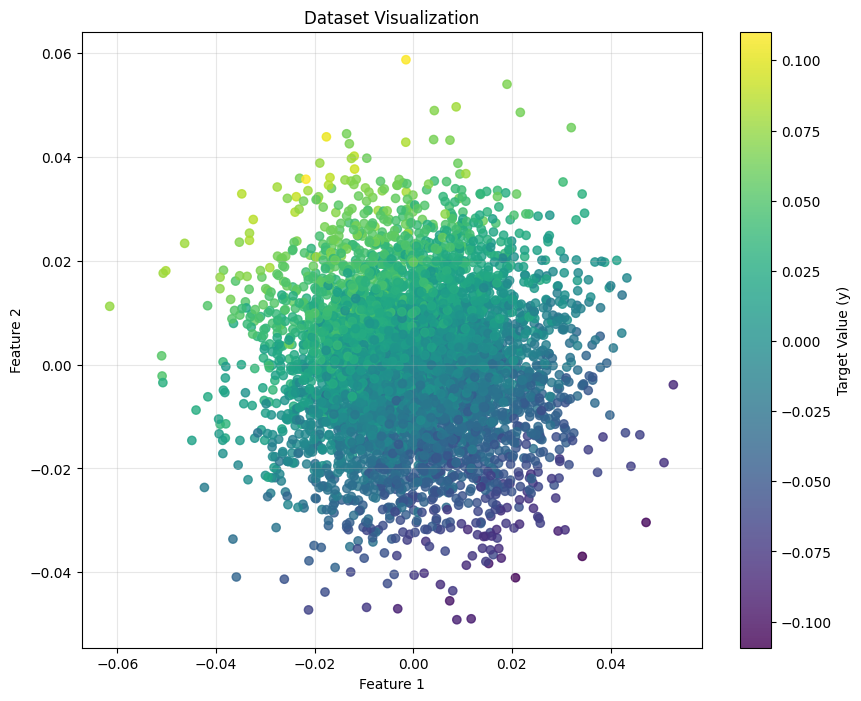

In [335]:
# Testing the generate_data function
kappa= 1
X, y, beta_star= generate_data(n= 5000, d= 2, kappa= kappa, seed= 42)
plot_2d_scatter(X.to(cpu_device), y.to(cpu_device))

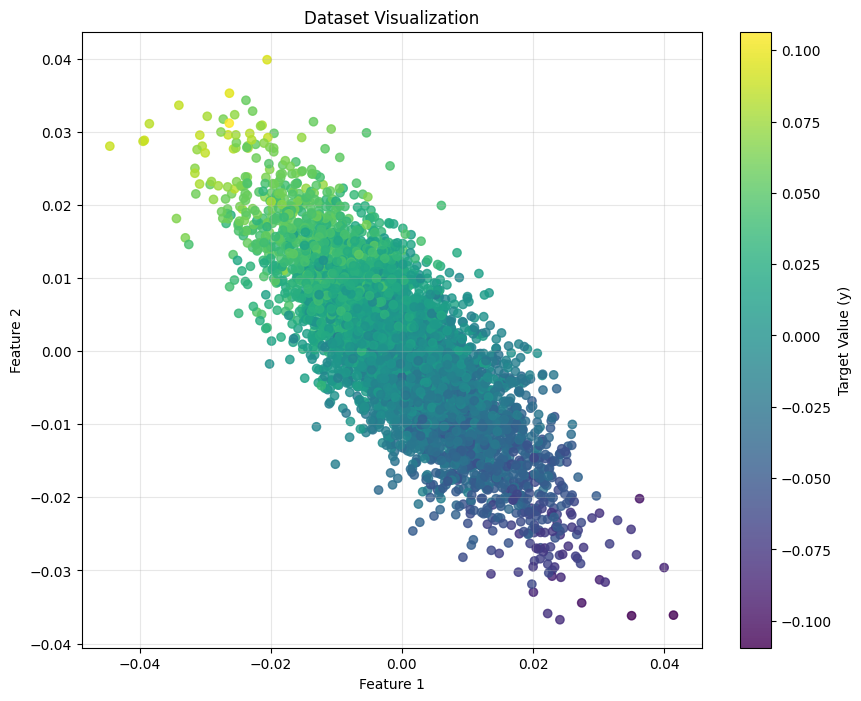

In [336]:
# Testing the generate_data function
kappa= 3
X, y, beta_star= generate_data(n= 5000, d= 2, kappa= kappa, seed= 42)
plot_2d_scatter(X.to(cpu_device), y.to(cpu_device))

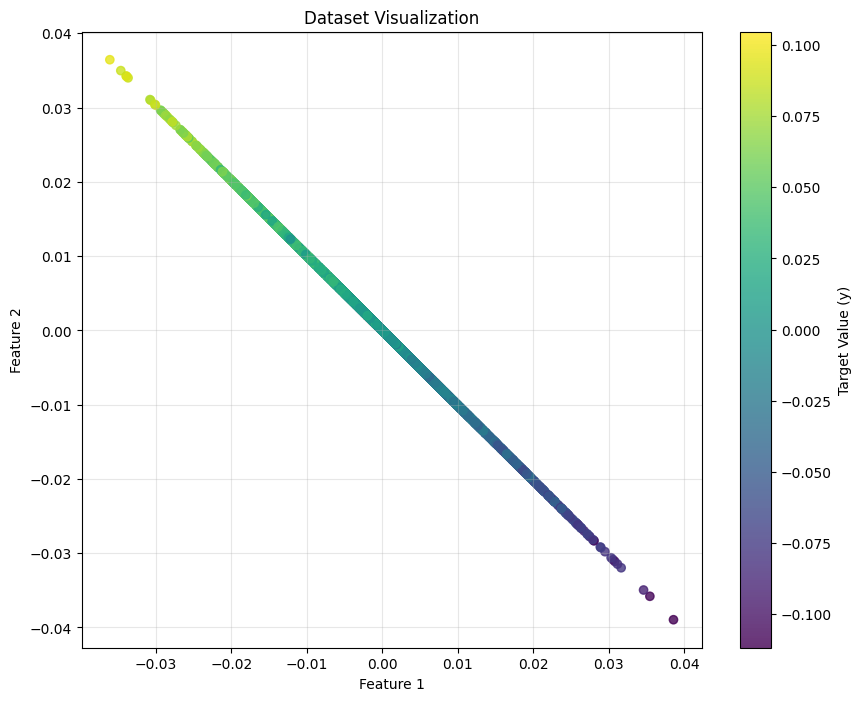

In [337]:
X_ill, y_ill, beta_star_ill= generate_data(n= 5000, d= 2, kappa= 1e5, seed= 42)
plot_2d_scatter(X_ill.to(cpu_device), y_ill.to(cpu_device))

## Closed Form Solution

This solution comes directly from minimizing L2 Loss (Mean Squared Error)

MSE is defined as:

$L(\beta) = \frac{1}{n}||X\beta - y||^2$

By taking the derivative with respect to B we get:

$\triangledown_\beta L(\beta)= 2/n (X^TX\beta - X^T y)$

Setting that to zero gives us the closed form solution:

$X^Ty=X^TX\beta$

Note:

The closed form solution is more accurate than gradient descent as it computes the exact mathematical optimum (in exact arithmetic). However, it isn't widely used for the following reasons:

1. **Computationally demanding**: It has a time complexity of $O(d^3)$ due to matrix inversion and a space complexity of $O(d^2)$ for storing $X^T X$.

2. **Numerically unstable**: When $X^T X$ is ill-conditioned (high condition number), small numerical errors can lead to large inaccuracies in the solution.

3. **Limited applicability**: Only works for linear models with differentiable convex losses that admit closed-form solutions (like MSE), whereas gradient descent can be applied to a much broader range of models (neural networks, non-linear models) and loss functions.

In [338]:
def closed_form_normal_equations(X, y):
    """
    Description:
        This is a solver function that computes the linear regression solution using normal equations
    Args:
        X: Feature matrix of shape (n, d)
        y: Target vector of shape (n,)
    Returns:
        beta_hat: Estimated coefficients of shape (d,)
    """
    # Form G= X^T X
    G= X.T @ X

    # Form b= X^T y
    b= X.T @ y

    # Solve G * beta= b using torch.linalg.solve
    # This is more stable than explicitly computing the inverse
    beta_hat= torch.linalg.solve(G, b)
    return beta_hat

In [339]:
def mse_loss(X, y, beta):
    """
    Description:
        Computes the mean squared error loss
    Args:
        X: Feature matrix of shape (n, d)
        y: Target vector of shape (n,)
        beta: Current parameters/coefficients of shape(d,)
    Returns:
        loss: The MSE loss as a scalar PyTorch tensor
    """
    # Number of samples
    n= X.shape[0]
    
    # Calculating residuals
    y_hat= X @ beta
    
    # Calculating residuals error: error= y_hat - y
    error= y_hat - y

    # Calculate squared L2 Norm of the error: ||error||_2^2
    # torch.norm(error, 2) computes L2 norm
    squared_l2_norm= torch.norm(error, 2).pow(2)

    loss= squared_l2_norm / n
    return loss

In [340]:
def gradient_descent(X, y, learning_rate= 0.05, max_iters= 10000, tol= 1e-12):
    """
    Description:
        Perform gradient descent using autograd to solve linear regression
    Args:
        X: Feature matrix of shape (n,d)
        y: Target vector of shape (d,)
        learning_rate: Step size for gradient descent
        tol: Tolerance for early stopping
    """

    # Initialize parameters with requires_grad= True for grad tracking and computation
    beta= torch.zeros(X.shape[1], requires_grad= True)

    # Store loss history
    loss_history= []

    # Optimization loop
    for i in range(max_iters):
        # Forward pass: Compute Loss
        loss= mse_loss(X, y, beta)
        loss_history.append(loss.item())

        # Backward Pass: Compute gradients
        loss.backward()

        # Update parameters using gradient descent
        with torch.no_grad():
            beta -= learning_rate * beta.grad

            # Check for convergence after at least 5 iterations
            if i > 5 and abs(loss_history[-5] - loss_history[-1]) < tol:
                break
            
            # Zero gradients for next iteration
            beta.grad.zero_()

    return beta.detach(), loss_history

In [341]:
def numerical_gradient(X, y, beta, h=1e-5):
    """
    Compute numerical gradient using central differences.
    
    Args:
        X: Feature matrix of shape (n, d)
        y: Target vector of shape (n,)
        beta: Parameter vector of shape (d,)
        h: Small perturbation for numerical differentiation
        
    Returns:
        grad: Numerical gradient of shape (d,)
    """
    grad = torch.zeros_like(beta)
    
    for i in range(len(beta)):
        # Create perturbed vectors
        beta_plus = beta.clone()
        beta_minus = beta.clone()
        
        # Perturb the i-th parameter
        beta_plus[i] += h
        beta_minus[i] -= h
        
        # Compute loss at perturbed points
        loss_plus = mse_loss(X, y, beta_plus)
        loss_minus = mse_loss(X, y, beta_minus)
        
        # Central difference approximation
        grad[i] = (loss_plus - loss_minus) / (2 * h)
    
    return grad

def gradient_check(X, y, beta_init=None):
    """
    Compare autograd and numerical gradients.
    
    Args:
        X: Feature matrix of shape (n, d)
        y: Target vector of shape (n,)
        beta_init: Initial parameter vector (if None, use random)
        
    Returns:
        rel_error: Relative error between gradients
    """
    if beta_init is None:
        beta_init = torch.randn(X.shape[1])
    
    # Compute autograd gradient
    beta = beta_init.clone().requires_grad_(True)
    loss = mse_loss(X, y, beta)
    loss.backward()
    autograd_grad = beta.grad
    
    # Compute numerical gradient
    numerical_grad = numerical_gradient(X, y, beta_init)
    
    # Calculate relative error
    rel_error = relative_error(autograd_grad, numerical_grad)
    
    return rel_error.item()

In [342]:
def compare_solutions(X, y, learning_rate=0.01, max_iters=1000):
    """
    Compare closed-form and gradient descent solutions.
    
    Args:
        X: Feature matrix of shape (n, d)
        y: Target vector of shape (n,)
        learning_rate: Learning rate for GD
        max_iters: Maximum iterations for GD
        
    Returns:
        beta_closed: Closed-form solution
        beta_gd: Gradient descent solution
        loss_history: Loss history from GD
        solution_error: Relative error between solutions
    """
    # Compute closed-form solution
    beta_closed = closed_form_normal_equations(X, y)
    
    # Compute gradient descent solution
    beta_gd, loss_history = gradient_descent(X, y, learning_rate, max_iters)
    
    # Compute loss for closed form solution
    closed_form_loss= mse_loss(X, y, beta_closed)
    
    # Compute loss for gd solution
    gd_loss= mse_loss(X, y, beta_gd)

    # Calculate relative error between solutions
    solution_error = loss_difference(closed_form_loss, gd_loss).item()
    
    return beta_closed, beta_gd, loss_history, solution_error

In [343]:
def plot_loss(loss_history, title="Loss vs Iterations"):
    """
    Plot loss over iterations.
    
    Args:
        loss_history: List of loss values
        title: Plot title
    """
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history, 'b-', linewidth=2)
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('MSE Loss')
    plt.grid(True, alpha=0.5)
    plt.yscale('log')  # Use log scale for better visualization
    plt.show()

# Main experiment
def run_experiment(n=100, d=2, kappa= 1, noise_std=0.1, learning_rate=0.1, max_iters=10000):
    """
    Run the complete experiment.
    
    Args:
        n: Number of samples
        d: Number of features
        kappa: Condition number
        noise_std: Noise standard deviation
        learning_rate: Learning rate for GD
        max_iters: Maximum iterations for GD
    """
    # Generate synthetic data
    X, y, beta_star = generate_data(n, d, kappa, noise_std)
    
    # Perform gradient check
    grad_error = gradient_check(X, y)
    print(f"Gradient check relative error: {grad_error:.2e}")
    print(f"Gradient check passed: {grad_error < 1e-5}")
    
    # Compare solutions
    beta_closed, beta_gd, loss_history, solution_error = compare_solutions(
        X, y, learning_rate, max_iters
    )
    
    print(f"\nSolution comparison:")

    print(f"Relative error between closed-form and GD: {solution_error:.2e}")
    print(f"GD converged to near closed-form solution: {solution_error < 0.1}")
    print(f"Beta Closed Loss: {mse_loss(X, y, beta_closed)}")
    print(f"Beta GD Loss: {mse_loss(X, y, beta_gd)}")
    
    # Plot loss history
    plot_loss(loss_history, f"Loss vs Iterations (kappa={kappa}, lr={learning_rate})")
    
    # Return results for further analysis if needed
    return {
        'X': X,
        'y': y,
        'beta_star': beta_star,
        'beta_closed': beta_closed,
        'beta_gd': beta_gd,
        'loss_history': loss_history,
        'grad_error': grad_error,
        'solution_error': solution_error
    }


Gradient check relative error: 1.10e-12
Gradient check passed: True

Solution comparison:
Relative error between closed-form and GD: 3.20e-03
GD converged to near closed-form solution: True
Beta Closed Loss: 0.010030117959902978
Beta GD Loss: 0.013230252463935574


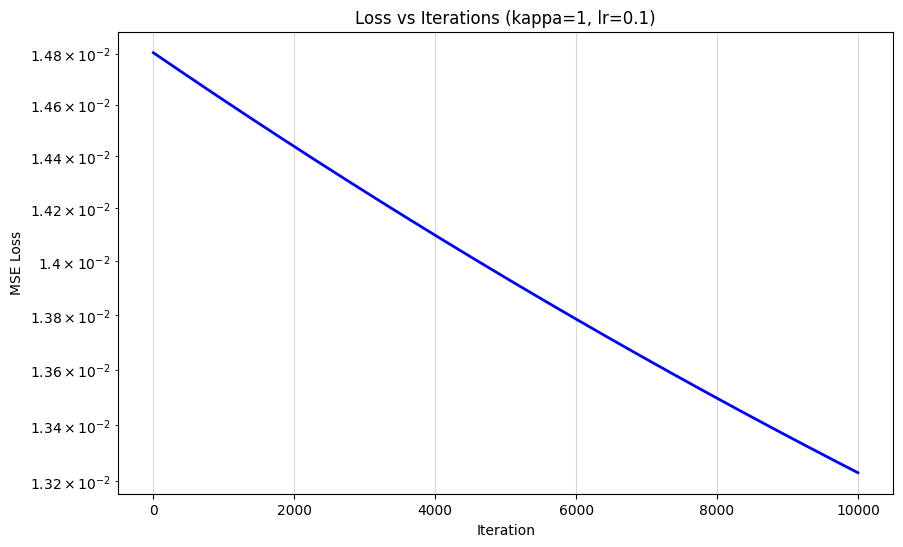

In [344]:
# Run the experiment on well conditioned data
results = run_experiment(n= 10000, d= 50, kappa= 1, noise_std= 0.1, learning_rate= 0.1, max_iters= 10000)

Gradient check relative error: 5.83e-13
Gradient check passed: True

Solution comparison:
Relative error between closed-form and GD: 1.96e-04
GD converged to near closed-form solution: True
Beta Closed Loss: 0.009845901432924735
Beta GD Loss: 0.010041897465452657


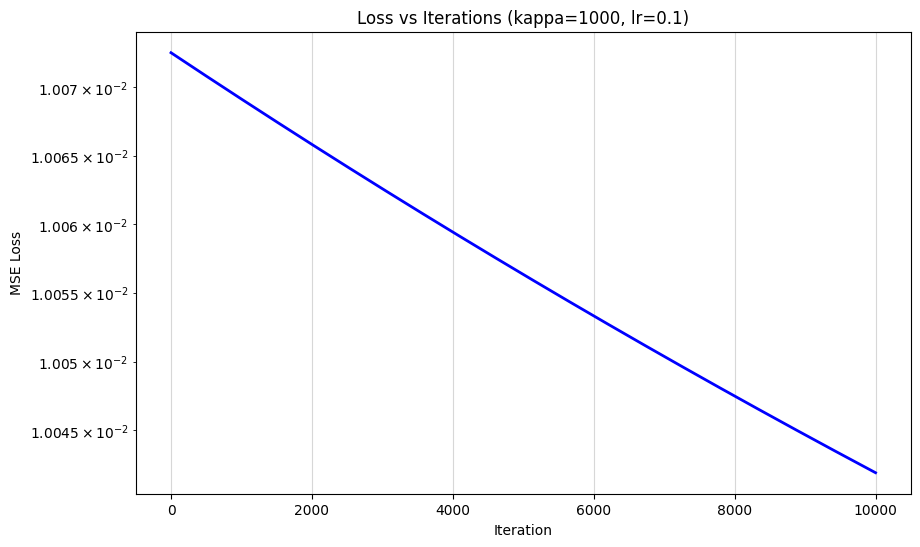

In [345]:
# Run the experiment on ill conditioned data
results = run_experiment(n= 10000, d= 50, kappa= 1000, noise_std= 0.1, learning_rate= 0.1, max_iters= 10000)